# Исследование возможностей SIMD-инструкций на примере задачи о расчете множества Мандельброта

## Введение
_Множеством Мандельброта_ называется множество точек $z_0$ комплексной плоскости, для которых 
рекуррентное соотношение $z_{n+1} = z_n^2 + z_0$ задает ограниченную последовательность,
то есть существует окружность радиуса $R$ такая, что 
$\forall n \in\{0, 1, ...\} \ | z_n | < R$.

Рассмотрим следующую задачу:
пусть начиная с некоторого номера $N$ точки последовательности $z_n$ более не принадлежат
окружности. Будем рассматривать функцию $N(z)$ в прямоугольнике $w \times h$. 
По значениям этой функции в конкретной точке
выбирается ее цвет, таким образом прямоугольник определенным образом раскрашивается.

Несложно заметить, что данный алгоритм предполагает большое количество вычислений и
процесс может занимать довольно много времени, ведь его асимптотика $O(Cwh)$.
Таким образом, возникает желание ускорить вычисления. Для этого естественно применить
параллелизацию, чтобы считать больше точек за раз. В современных процессорах
такая возможность реализована в виде _SIMD-инструкций_, выполняющих
операции не над одним скаляром, а сразу над вектором фиксированного размера. 

Данную работу мы будем выполнять на архитектуре x86-64.
В процессорах с этой архитектурой набор инструкций, реализующих принцип SIMD,
получил название AVX (_Advanced Vector Extensions_). AVX-инструкции реализованы 
аппаратно при помощи специальных регистров, способных хранить вектор целочисленных
значений размера 8, 16, 32 или 64 бита либо вектор значений с плавающей точкой 
одинарной или двойной точности.

## Оборудование
### Минимальные требования
Для успешного повторения эксперимента с данной программой требуется компьютер со следующей
конфигурацией:
| Характеристика | Требования |
|:---------:|:--------------:|
| Процессор | Архитектура x86-64, поддержка AVX2 |
| ОС        | Linux 64 bit   |
| Установленное ПО | Git, компилятор C++, система сборки, CMake |
| Установленное библиотеки | SFML, Fontconfig |

Корректная сборка и работа на конфигурациях, не соответствующих данным требованиям, не
гарантируется.

### Референсная система
Данная работа была выполнена на ноутбуке с процессором Intel Core i5-8400H Kaby Lake.

## Сборка
Для сборки данной программы с целью повторения эксперимента нужно:
1. Клонировать данный репозиторий вместе с подмодулями:
```
git clone https://github.com/victorbaldin56/mandelbrot_fractal --recursive
cd mandelbrot_fractal
```
2. Сконфигурировать проект при помощи CMake. Для версии `Release` через интерфейс командной
строки:
```
mkdir Release && cd Release
cmake .. -G <your build system> -DCMAKE_BUILD_TYPE=Release
```
3. Собрать проект при помощи любой доступной системы сборки.


## Реализация
### Рендер 
Для использования возможностей AVX-инструкций можно применять
соответвующие ассемблерные инструкции. Однако в нашем распоряжении есть компилятор
GCC, который поддерживает так называемые _интринсики_ 
([_intrinsics_](https://www.laruence.com/sse/#techs=MMX,SSE,SSE2,SSE3,SSSE3,SSE4_1,SSE4_2,AVX,AVX2,AVX_512)), 
что позволяет использовать их прямо из C++. 
Разумеется, это делает программу непереносимой на другие
архитектуры, но это оправдывается ускорением.

Для собственно отрисовки будем применять простую графическую библиотеку 
[SFML](https://www.sfml-dev.org/).
Общая последовательность вычислений при этом будет выглядеть следующим образом:
1. Проходим циклом по всем пикселям графического окна, пересчитываем его "натуральные" координаты
в координаты с плавающей точкой типа `float` с учетом масштаба и смещения начала координат.
Считаем $N(z)$ сразу для 8 соседних точек. При этом устанавливаем верхнюю границу $N_{max} = 256$,
чтобы предотвратить бесконечный цикл. Расчет прекращается в момент, когда все 8 точек вектора
оказываются за пределами окружности радиуса $R = 10$, либо счетчик достигает значения $N_{max}$.
Первоначально применялась наивная реализация, при которой $N(z)$ расчитывается для 
каждой отдельной точки.
Сохраняем значение вектора счетчиков в заранее заготовленный массив счетчиков. 
2. Пересчитываем значения счетчиков в RGBA цвета по формулам следующего вида:
```
R = CNT * R_COEFF % 256
G = CNT * G_COEFF % 256
B = CNT * B_COEFF % 256
A = 0xff
```
При `R_COEFF = 15`, `G_COEFF = 30`, `B_COEFF = 40` и размерах
окна $1024 \times 1024$ получим следующую картинку:
![image](./pictures/mand.png)

### Измерение производительности
Итак, у нас есть 2 разных имплементации для вычисления $N(z)$: наивная 
и с использованием AVX. Сравним их производительность. Для этого будем в цикле
вызывать непосредственно функцию вычисления счетчиков $C$ раз и измерять время.

С измерением времени все не так просто, как может показаться на первый взгляд. 
Наиболее очевидный и простой способ, функция `clock()` стандартной библиотеки
языка С, использует системный таймер, прерывание которого срабатывает раз в 10 мс
в Linux, что не слишком точно. Поэтому мы будем использовать метод, основанный 
на чтении текущего значения количества тактов процессора за время работы.
Современные процессоры компании Intel хранят это значение в специальном 
64-битном регистре, называемом TSC (_Time Stamp Counter_). Для доступа к
этому регистру применяется инструкция `rdtsc`. GCC предоставляет для
этой инструкции интринсик `__rdtsc()`, что облегчает использование.

Проблемой данного метода может быть непостоянство частоты процессора.
Однако современные процессоры имеют TSC, который инкрементируется с
эталонной частотой процессора. Проверить это можно, просмотрев 
содержимое файла `/proc/cpuinfo`. В экспериментальной системе он
содержит флаг `constant_tsc`, значит в данном случае это
действительно так.

Замеры произведем для 2-х версий программы: `Debug` и `Release`. Первая собрана
с ключом `-O0`, но без санитайзеров. Релизная версия собрана с максимально
возможной оптимзацией, даже выше стандартных уровней: `-Ofast -march=native`.
В обеих программах тестируется и наивная, и векторизованная имплементации.

Для максимальной частоты измерений выставим процессор в маскимальное состояние
производительности при помощи утилиты `cpupower`, а также завершим все лишние
приложения. Для еще большей уверенности проведем измерения 20 раз для каждой 
версии программы, при этом количество оборотов цикла подсчета 
будем увеливать начиная от 5 до 100 с шагом 5 (поскольку
наша методика измерения времени теоретически имеет очень высокую точность). 
Получим зависимость количества тактов TSC от количества итераций цикла 
расчета множества. Все указанные действия выполняет данный [скрипт](benchmark.sh).

Собранные описанным образом данные для версии [без оптимизации](data/no_optimization.csv),
[с оптимизацией](data/with_optimization.csv).
По полученным данным построим графики:


<table>
<thead>
<tr><th style="text-align: center;">                   </th><th style="text-align: center;"> No optimization </th><th style="text-align: center;"> With optimization </th></tr>
</thead>
<tbody>
<tr><td style="text-align: center;">Clocks on dumb, 1e5</td><td style="text-align: center;">    11447 ± 5    </td><td style="text-align: center;">     5023 ± 3      </td></tr>
<tr><td style="text-align: center;">Clocks on AVX2, 1e5</td><td style="text-align: center;">    1830 ± 1     </td><td style="text-align: center;">      679 ± 0      </td></tr>
<tr><td style="text-align: center;">   Acceleration    </td><td style="text-align: center;">  6.256 ± 0.005  </td><td style="text-align: center;">   7.399 ± 0.005   </td></tr>
</tbody>
</table>

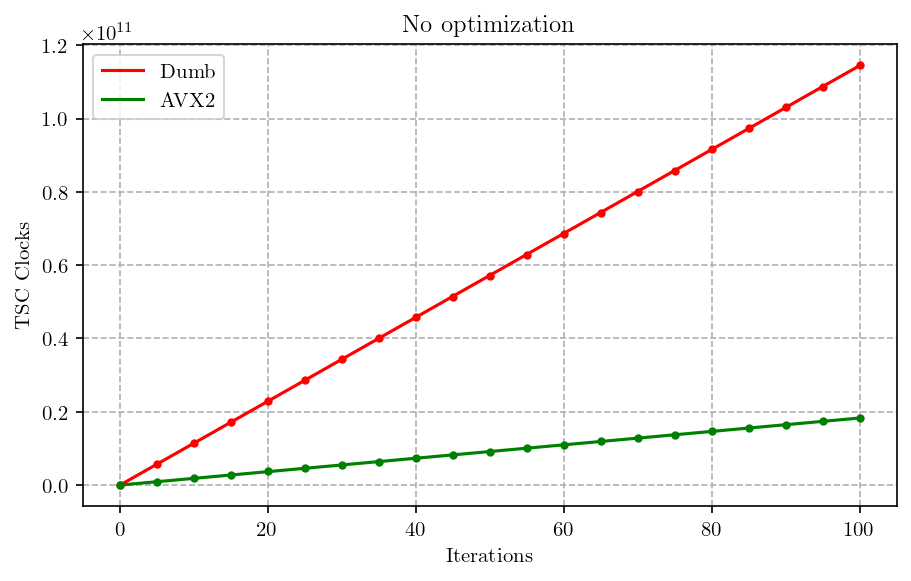

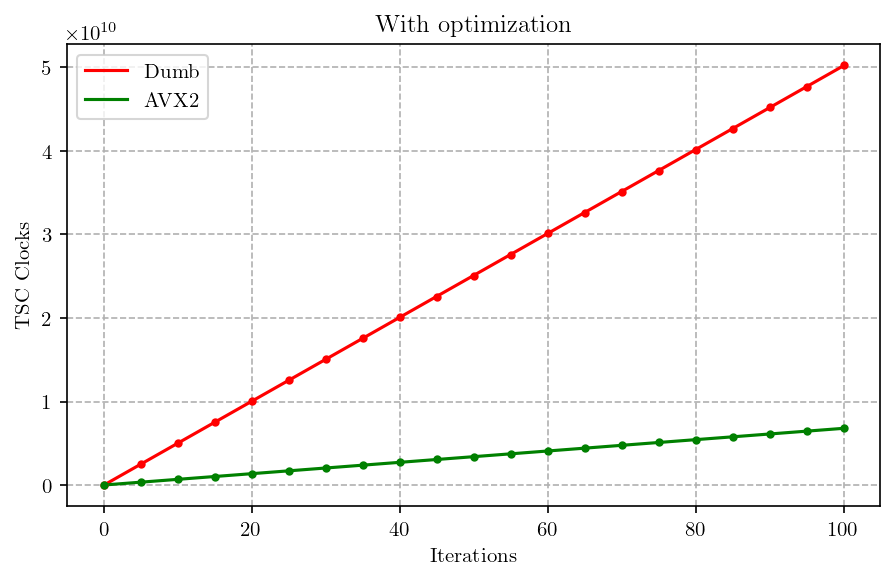

In [35]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.backends.backend_pgf import FigureCanvasPgf
from tabulate import tabulate
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)
from IPython.display import display_markdown

matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'figure.dpi': 150,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

def read_files(files):
    ret = []
    for f in files:
        ret += [pd.read_csv(f)]
    return ret

def main(df, title, filename, table):
    colors = ['red', 'green']
    labels = ['Dumb', 'AVX2']
    table[title] = []

    plt.figure(figsize=(7, 4))

    coeffs = []
    for i in range(labels.__len__()):
        plt.errorbar(df['N'], df[f'{labels[i]}'], xerr=0, yerr=0,
                     fmt=f'{colors[i][0]}.')
        [a, b], cov = np.polyfit(df['N'], df[labels[i]], deg=1, cov=True)
        diag = np.diag(cov)
        diag = np.sqrt(diag)
        epsilon = diag[0] / a

        coeffs.append([a, epsilon])
        table[title].append(f'{a / 1e5 :.0f} ± {diag[0] / 1e5 :.0f}')

        z = np.linspace(0, max(df['N']), 1000)
        plt.plot(z, a * z + b, color=colors[i], label=labels[i])

    alpha = coeffs[0][0] / coeffs[1][0]
    table[title].append(f'{alpha : .3f} ± {alpha * np.sqrt(coeffs[0][1]**2 + coeffs[1][1]**2) :.3f}')

    plt.title(title)
    plt.grid(linestyle='--')
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('TSC Clocks')
    plt.savefig(f'pictures/{filename}')

dfs = read_files(['data/no_optimization.csv', 'data/with_optimization.csv'])
titles = ['No optimization', 'With optimization']
filenames = ['no_optimization.pdf', 'with_optimization.pdf']
table = {
    '': ['Clocks on dumb, 1e5', 'Clocks on AVX2, 1e5', 'Acceleration'],
}

for i in range(dfs.__len__()):
    main(dfs[i], titles[i], filenames[i], table)

temp_html = tabulate(table, headers='keys', tablefmt='html', stralign='center')
display_markdown(temp_html, raw=True)


Здесь мы не учитывали системную погрешность `rdtsc` ввиду того, что она очевидно ничтожно
мала. Случайная погрешность, связанная с возможным влиянием вшешних факторов, очевидноgg
сильно выше. Но и она, как видно, очень мала, относительная погрешность 
$\varepsilon \sim 10^{-4}$. Это позволяет говорить, что измерения были довольно
качественными.

### Анализ оптимизаций компилятора
Для анализа оптимизаций компилятора, применим инструмент
[godbolt](godbolt.org). Сначала расммотрим наивную имплементацию:
https://godbolt.org/z/3nWPh84zY.

![image](pictures/godbolt_dumb.png)

При самом поверхностном рассмотрении можно заметить, что ключевое
слово `inline`, указанное для функции `mf_calculate_point_counter()` сработало
лишь с оптимизацией. Основной используемый флаг: `-Ofast -march=x86-64-v3`.
Так же компилятор применил комнаду `lea` для размещения счетчика в 
массиве. Можно заметить сильное переупорядочивание инструкций,
ставшее возможным в том числе благодаря инлайну функции.

Похожим образом сработали оптимизации и в векторной реализации:
https://godbolt.org/z/a66M17961.

![image](pictures/godbolt_avx1.png)

## Вывод
Как видно из результатов работы, оптимизации компилятора не смогли 
векторизовать вычисления. Это показывает, что в определенных случаях
знание возможностей конкретной аппаратуры и умение их применять позволяет
достигнуть в разы лучшего результата, нежели надежда на компилятор.
